INTRODUCTION

In today's interconnected world, social media influences not only our personal lives but also the daily operations of businesses. For companies, understanding public sentiment about their products and brands is essential for adapting to shifting trends quickly—or even staying ahead of them. By staying informed, businesses can maintain relevance and seize opportunities for financial success.

A clear example of this is when major companies like Apple and Google host keynotes, such as Apple's WWDC or Google's I/O, where they unveil new products and software updates while teasing future changes. These events, along with senior leadership appearances at conferences where they share the company's vision, provide valuable opportunities for marketing teams to gauge interest and gather insights on public opinion.

Twitter serves as a powerful platform for assessing public sentiment, with millions of users sharing their thoughts daily. For this project, we were commissioned by Apple to conduct a sentiment analysis of tweets from the SXSW (South by Southwest) Conference. The key questions we aim to address are:

How is Apple perceived as a company during the SXSW Conference, and how does this perception compare to that of Google, its main competitor?

How are the products and announcements from Apple and Google received at the SXSW Conference? Are there specific pain points in Apple’s products that need to be addressed?

Furthermore, we will be training and testing various machine learning models to classify tweets based on sentiment. Apple can utilize these models to better understand public opinion and stay ahead of the competition.

In [979]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
import string
import re
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB


from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_colwidth', 10000)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package omw-1.4 is already up-to-date!


**Loading the Data**

We will utilize a dataset from data.world, provided by CrowdFlower, containing tweets about Apple and Google from the South by Southwest (SXSW) conference. The labels for these tweets were crowdsourced, indicating the emotions they convey and the specific product, service, or company to which these emotions are directed based on the content.

In [980]:
# Loading the Data from the source i.e. csv

df = pd.read_csv(r'..\\data\\judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

tweet_text  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [981]:
# Previewing the bottom of our dataset
df.tail()

tweet_text  \
9088                                                                                                                      Ipad everywhere. #SXSW {link}   
9089                      Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091       Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.   
9092                                           Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link}   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

**Data Cleaning**

The column names are overly long and challenging to read. We can simplify and rename them to enhance both readability and interpretability.

In [982]:
#rename columns for readability
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product/Brand', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head()

Tweet  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

        Product/Brand         Sentiment  
0              iPhone  Negative emotion  
1  iPad or iPhone App  Positive emotion  
2                iPad  Positive emotion  
3  iPad or iPhone App  Negative emotion  
4              Google  Positive emotion

Next, let's examine the unique values in the Product/Brand and Sentiment columns to understand what data we are working with.

In [983]:
df['Sentiment'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [984]:
df['Product/Brand'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

The dataset provides comprehensive information on a range of services and products for each company, as well as instances of null values and an "I can't tell" emotion. We will address these issues in the subsequent analysis.

**Addressing Missing and Placeholder Values**


In [985]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Duplicates and Null values


In [986]:
#looking at data, duplicates and null values
print(df.info())
print(("-"*20))

# Check for duplicated rows
print('Total duplicated rows')
print(df.duplicated().sum())
print(("-"*20))

# Check for null values
print('Total null values')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
Total duplicated rows
22
--------------------
Total null values
Tweet               1
Product/Brand    5802
Sentiment           0
dtype: int64


The DataFrame contains 22 duplicate rows. This means there are 22 entries that are identical across all columns. Whereas the Product/Brand has 5801 a significant number of missing values.

Cleaning the Tweet Column 



In [987]:
df = df[df['Tweet'].isna() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [988]:
#drop any NaN in the Tweet column
df['Tweet'].dropna(inplace=True)
df

Tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                                                                                                 ...   
9088                                                                                                                      Ipad everywhere. #SXSW {link}   
9089                      Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091       Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.   
9092                                           Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link}   

           Product/Brand                           Sentiment  
0                 iPhone                    Negative emotion  
1     iPad or iPhone App                    Positive emotion  
2                   iPad                    Positive emotion  
3     iPad or iPhone App                    Negative emotion  
4                 Google                    Positive emotion  
...                  ...                                 ...  
9088                iPad                    Positive emotion  
9089                 NaN  No emotion toward brand or product  
9090                 NaN  No emotion toward brand or product  
9091                 NaN  No emotion toward brand or product  
9092                 NaN  No emotion toward brand or product  

[9092 rows x 3 columns]

Checking the contents in the product and sentiment columns



In [989]:
df[df['Product/Brand'].isna()].head()
print(df)

                                                                                                                                                  Tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                   

In [990]:
df['Product/Brand'].fillna('Unknown', inplace=True)
print(df)

                                                                                                                                                  Tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                   

In [991]:
# Print the value count of product and sentiment column
print(df['Product/Brand'].value_counts())
print(("-"*20))
print(df['Sentiment'].value_counts())

Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: Product/Brand, dtype: int64
--------------------
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Sentiment, dtype: int64


Similar to the initial column names, the values in the emotion column can be cleaned up a bit for easy interpretability and to shorten the amount of typing for the code.

In [992]:
Sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['Sentiment'] = df['Sentiment'].map(Sentiment_dict)
df.head()

Tweet  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

        Product/Brand Sentiment  
0              iPhone  Negative  
1  iPad or iPhone App  Positive  
2                iPad  Positive  
3  iPad or iPhone App  Negative  
4              Google  Positive

In [993]:
df['Sentiment'].value_counts()


Neutral     5388
Positive    2978
Negative     570
Unknown      156
Name: Sentiment, dtype: int64

Now we can take a look at the tweets with "Unknown" emotion values to see if we can notice any patterns or tell easily whether the tweet has a negative, neutral or positive emotion.



In [994]:
pd.set_option("display.max_colwidth", 300)
df[df['Sentiment']=='Unknown']

Tweet  \
90                                     Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh   
102                         ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow   
237                              Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
341                                                                          The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw   
368                                       Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}   
...                                                                                                                                                     ...   
9020              It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW   
9032                                                                                    @mention yeah, we have @mention , Google has nothing on us :) #SXSW   
9037                                                                      @mention Yes, the Google presentation was not exactly what I was expecting. #sxsw   
9058  &quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?   
9066                    How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The influencer/hipsters thank you   

     Product/Brand Sentiment  
90         Unknown   Unknown  
102        Unknown   Unknown  
237        Unknown   Unknown  
341        Unknown   Unknown  
368        Unknown   Unknown  
...            ...       ...  
9020       Unknown   Unknown  
9032       Unknown   Unknown  
9037       Unknown   Unknown  
9058       Unknown   Unknown  
9066         Apple   Unknown  

[156 rows x 3 columns]

In [995]:
df = df[df['Sentiment']!='Unknown']
df['Sentiment'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: Sentiment, dtype: int64

Checking for and Addressing Duplicates

Now that we've addressed null values, and cleaned up our dataset a little bit more, next step is to check for duplicates to see if we have the same tweets represented multiple times.



In [996]:
len(df[df.duplicated()])


22

    We have 22 tweets that are duplicated in the dataset. Let's take a look at the duplicates for reference.



In [997]:
df[df.duplicated()]


Tweet  \
468                                                                                                     Before It Even Begins, Apple Wins #SXSW {link}   
776                                                              Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
2232                                                Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw   
2559                                                          Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   
3950  Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW   
3962        #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan   
4897                   Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!   
5338                                          RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter   
5341                     RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter   
5881                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
5882                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW   
5883                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
5884                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW   
5885                                                 RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
6296                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw   
6297                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW   
6298                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw   
6299                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW   
6300                                    RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw   
6546                                     RT @mention RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw   
8483                  I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone   
8747                                        Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Apple store?   

           Product/Brand Sentiment  
468                Apple  Positive  
776              Unknown   Neutral  
2232             Unknown   Neutral  
2559               Apple  Positive  
3950         Android App  Positive  
3962             Android  Positive  
4897  iPad or iPhone App  Positive  
5338             Unknown   Neutral  
5341             Unknown   Neutral  
5881             Unknown   Neutral  
5882             Unknown   Neutral  
5883             Unknown   Neutral  
5884             Unknown   Neutral  
5885             Unknown   Neutral  
6296              Google  Positive  
6297      

In [998]:
#Drop the duplicats
df.drop_duplicates(keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          8914 non-null   object
 1   Product/Brand  8914 non-null   object
 2   Sentiment      8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


In [999]:
#looking at sentitmental breakdown of brands
display(df.groupby(['Sentiment'])['Product/Brand'].value_counts(normalize = True))
print("-"*60)
display(df.groupby(['Product/Brand'])['Sentiment'].value_counts(normalize = True))

Sentiment  Product/Brand                  
Negative   iPad                               0.219684
           iPhone                             0.179262
           Apple                              0.166960
           Google                             0.119508
           iPad or iPhone App                 0.110721
           Unknown                            0.089631
           Other Google product or service    0.082601
           Android                            0.014060
           Android App                        0.014060
           Other Apple product or service     0.003515
Neutral    Unknown                            0.983070
           iPad                               0.004465
           Apple                              0.003907
           Google                             0.002791
           iPad or iPhone App                 0.001860
           Other Google product or service    0.001674
           iPhone                             0.001674
           Android    

------------------------------------------------------------


Product/Brand                    Sentiment
Android                          Positive     0.883117
                                 Negative     0.103896
                                 Neutral      0.012987
Android App                      Positive     0.887500
                                 Negative     0.100000
                                 Neutral      0.012500
Apple                            Positive     0.823440
                                 Negative     0.144597
                                 Neutral      0.031963
Google                           Positive     0.805621
                                 Negative     0.159251
                                 Neutral      0.035129
Other Apple product or service   Positive     0.914286
                                 Negative     0.057143
                                 Neutral      0.028571
Other Google product or service  Positive     0.808219
                                 Negative     0.160959
                      

In [1000]:
#Number of Tweets per product
print(df["Product/Brand"].value_counts())
print("-"*60)
#Number of Tweets per Sentiment
print(df["Sentiment"].value_counts())
print("-"*60)
#Number of Tweet per Brand
print(df["Product/Brand"].value_counts())
print("-"*60)

Unknown                            5641
iPad                                941
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product/Brand, dtype: int64
------------------------------------------------------------
Neutral     5375
Positive    2970
Negative     569
Name: Sentiment, dtype: int64
------------------------------------------------------------
Unknown                            5641
iPad                                941
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Oth

In [1001]:
#Final DataFrame before Preprocessing
df

Tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                                                                                                 ...   
9088                                                                                                                      Ipad everywhere. #SXSW {link}   
9089                      Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091       Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.   
9092                                           Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link}   

           Product/Brand Sentiment  
0                 iPhone  Negative  
1     iPad or iPhone App  Positive  
2                   iPad  Positive  
3     iPad or iPhone App  Negative  
4                 Google  Positive  
...                  ...       ...  
9088                iPad  Positive  
9089             Unknown   Neutral  
9090             Unknown   Neutral  
9091             Unknown   Neutral  
9092             Unknown   Neutral  

[8914 rows x 3 columns]

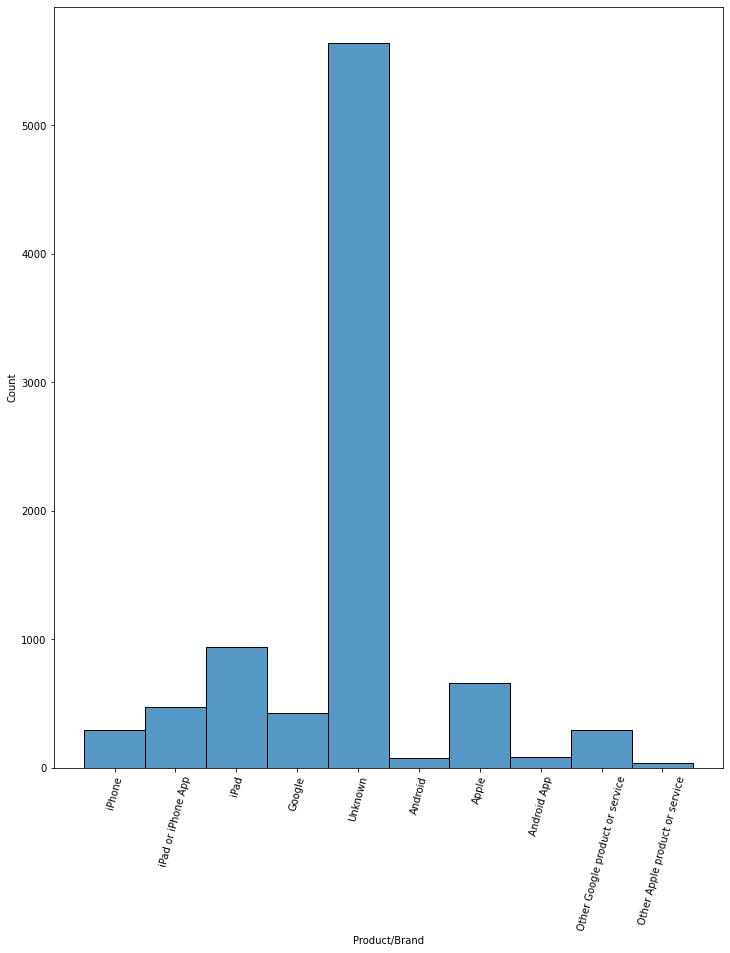

In [1002]:
#Plot to check the distribution
fig, ax = plt.subplots(figsize=(12,14))
sns.histplot(df["Product/Brand"] )
plt.xticks(rotation = 75)
plt.show()

EXPLORATORY DATA ANALYSIS


With the business problem in mind, it is important to isolate and analyze positive and negative tweets as a whole as well as on a company and product basis. We will start our exploration with positive tweets.



Tweets with Positive Sentiment

Lets explore the data where we have positive sentiments . 

In [1003]:
#parsing positive tweets into new df
df_positive = df[df['Sentiment']=='Positive']
#verifying that neutral and negative tweets have been removed
df_positive['Sentiment'].value_counts()

Positive    2970
Name: Sentiment, dtype: int64

In [1004]:
#parsing tweets into a list
corpus_pos = df_positive['Tweet'].to_list()
corpus_pos[:5]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

Tokenization

For tokenizing the tweets we will be using the TweetTokenizer throughout this project since it has built-in functionality such as processing handles and hashtags correctly unlike other tokenizers. We will drop any handles from the tweets since we are mainly focused on the content of the tweet.

In [1005]:
from nltk import TweetTokenizer
import string

def tokenize_tweets(corpus, preserve_case=False, strip_handles=True):
    """
    Tokenizes a collection of tweets into individual tokens.

    Parameters:
    - corpus: A collection of tweets in a format suitable for tokenization.
    - preserve_case: If True, preserves uppercase letters; otherwise, converts to lowercase.
    - strip_handles: If True, removes Twitter handles from the tokens.

    Returns:
    - A list of tokens extracted from the tweets.
    """
    # Initialize the TweetTokenizer with the specified options
    tokenizer = TweetTokenizer(preserve_case=preserve_case, 
                               strip_handles=strip_handles)
    
    # Join the corpus into a single string and tokenize it
    tokens = tokenizer.tokenize(' '.join(corpus))
    return tokens


In [1006]:
#tokenize positive tweets
tokens_pos = tokenize_tweets(corpus_pos)

In [1007]:
#displaying 10 most common tokens
from nltk import FreqDist
freq = FreqDist(tokens_pos)
freq.most_common(10)

[('#sxsw', 2984),
 ('.', 2227),
 ('the', 1590),
 ('!', 1241),
 ('link', 1214),
 ('{', 1210),
 ('}', 1210),
 ('to', 1154),
 (',', 1096),
 ('at', 1019)]

We can see that our tokens contain a lot of punctuation and stop words like "to" and "at" since we haven't removed these yet. Prior to removing these though, we will be lemmatizing the tokens to make sure we're capturing any stop words that may be generated with this process.

Lemmatization


In [1008]:
from nltk.stem import WordNetLemmatizer
from typing import List

def lemmatize_tokens(tokens_list: List[str]) -> List[str]:
    """
    Lemmatizes a list of tokens using WordNetLemmatizer.

    Parameters:
    - tokens_list: A list of tokens to be lemmatized.

    Returns:
    - A list of lemmatized tokens.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each token in the list
    tokens_lemm = [lemmatizer.lemmatize(word) for word in tokens_list]
    return tokens_lemm


In [1009]:
#lemmatizing positive tweet tokens
tokens_pos_lemm = lemmatize_tokens(tokens_pos)

In [1010]:
#displaying most common 10 tokens
from nltk import FreqDist
freq = FreqDist(tokens_pos_lemm)
freq.most_common(10)

[('#sxsw', 2984),
 ('.', 2227),
 ('the', 1590),
 ('!', 1241),
 ('link', 1218),
 ('{', 1210),
 ('}', 1210),
 ('to', 1154),
 (',', 1096),
 ('at', 1019)]

Punctuation and stop words remain in our list. After lemmatizing tokens, we'll remove these elements as they don't significantly impact tweet sentiment. This removal will highlight more relevant information and enhance model performance.

Stop Word/Punctuation Removal


In [1011]:
import string
from nltk.corpus import stopwords

# Retrieve the English stopwords from NLTK
stop_lst = stopwords.words('english')

# Add punctuation characters to the stop words list
stop_lst.extend(list(string.punctuation))

# Add additional characters and empty string to the stop words
additional_punctuation = ['“', '”', '...', "''", '’', '``', '']
stop_lst.extend(additional_punctuation)


In [1012]:
from typing import List

def remove_stop(tokens: List[str], stop_list: List[str] = stop_lst) -> List[str]:
    """
    Removes stop words from a list of tokens.

    Parameters:
    - tokens: A list of tokens from which to remove stop words.
    - stop_list: A list of stop words to be removed (default is the predefined stop_lst).

    Returns:
    - A list of tokens with stop words removed.
    """
    # Remove unrecognized symbols and external links
    tokens_stopped = [
        word.encode('ascii', 'ignore').decode() 
        for word in tokens 
        if word not in stop_list and not word.startswith('http')
    ]
    
    return tokens_stopped


In [1013]:
# Remove stop words from the lemmatized tokens
tokens_pos_ls = remove_stop(tokens_pos_lemm)


In [1014]:
#displaying most common 50 tokens
freq = FreqDist(tokens_pos_ls)
freq.most_common(50)

[('#sxsw', 2984),
 ('link', 1218),
 ('ipad', 1010),
 ('rt', 935),
 ('apple', 711),
 ('google', 603),
 ('2', 595),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 359),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('sxsw', 144),
 ('line', 143),
 ('great', 136),
 ('time', 136),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('free', 120),
 ('cool', 119),
 ("i'm", 115),
 ('like', 115),
 ('map', 115),
 ('one', 114),
 ('win', 112),
 ('today', 111),
 ('ha', 108),
 ('circle', 107),
 ('w', 104),
 ('go', 104),
 ('come', 103),
 ('wa', 100),
 ('#sxswi', 96),
 ('awesome', 93),
 ('#ipad', 93),
 ('love', 93),
 ('good', 92),
 ('network', 91),
 ('mobile', 90),
 ('temporary', 89),
 ('downtown', 88)]

Our updated list of the 50 most common words still contains some that don't provide useful information about tweet sentiment. Since we know these tweets are from the SXSW Conference, we can remove hashtags like "#sxsw" by adding them to our stop words list. Words such as "link" and "rt" likely refer to external links and retweets, respectively. However, "link" might also be used in its dictionary sense. To understand how a word appears in our corpus, we can create a function that:

1. Takes a random sample of tweets from the corpus
2. Checks if our target word appears in any of these tweets
3. Displays the tweets containing the word

This approach will help us better understand the context and usage of specific words in our dataset.

In [1015]:
#adding sxsw to stop list
stop_lst += ['#sxsw', '#sxswi', 'sxsw']

In [1016]:
import numpy as np
from typing import List

def context_finder(word: str, corpus: List[str], n_samples: int = 5, n_count: int = 5) -> None:
    """
    Provides context for a specified word by sampling tweets from a given corpus.

    Parameters:
    - word: The word for which context is being sought.
    - corpus: A list of tweets (the document containing the word).
    - n_samples: The number of samples to collect from the corpus.
    - n_count: The number of tweets in each sample.

    Returns:
    - None
    """
    
    total_tweets_analyzed = 0
    matching_tweets_count = 0
    
    for _ in range(n_samples):
        sample = np.random.choice(corpus, n_count)
        for tweet in sample:
            if word in tweet:
                print(tweet)
                matching_tweets_count += 1
                total_tweets_analyzed += 1

    print('-----------------------------------')
    print(f'Out of {total_tweets_analyzed} tweets analyzed, '
          f'{matching_tweets_count} tweets contained the word "{word}".')


In [1017]:
# Verify that the word 'link' is used in reference to external web links
context_finder('link', corpus_pos)


Google web fonts...pretty... #sxsw #tradeshow {link}
HOORAY RT ÛÏ@mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}
RT @mention Apple set to open popup shop in core of SXSW action {link} via @mention #SXSW
building on the success of Google Buzz no doubt ;) RT @mention Google to launch Circles social network at #sxsw? {link}
RT @mention Word to your motherboard. RT @mention You'll want these iPhone apps if you're heading to #SXSW today. 10 hot ones. {link}
Before It Even Begins, Apple Wins #SXSW {link} /by @mention for @mention
RT @mention RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw (via @mention #pcbuzz
Heading to Austin for #SXSW? The @mention Austin guide for #iPhone is free for a limited time {link} #lp #travel
RT @mention Apple Popup Store at #SXSW {link} (Sat AM at opening)
Apple saves SXSW, set to open pop-up store {link} #Apple #SXSW
Free iTunes Album, #SXSW Featured Artists, grab it if you missed

Analysis reveals that 'link' primarily refers to web links removed during dataset parsing. Since this doesn't offer meaningful insights into tweet content, we can confidently add 'link' to our stop words list.

In [1018]:
stop_lst += ['link']


Now, we can take a look at 'RT' to confirm that it was used to refer to retweets.



In [1019]:
context_finder('RT', corpus_pos)


RT @mention Having fun creating a dynamic Google doc with @mention from opposite sides of the #killcommunity room #sxsw
RT @mention My informal unscientific observation is that #Apple is by far the computer of choice at #SXSW. Hands down.  No contest.
Congrats!!! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw
{link} RT @mention 1st stop on the #SXSW #Chaos &amp; @mention hunt: Austin Java. Get in the spy game 4 a chance 2 win an iPad!
RT @mention 40% of Google maps use is mobile #sxsw
Yay! RT @mention Hoot! New Blog post: HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android {link}
RT @mention RT @mention It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW + #iPad2 launch {link}
RT @mention At Google, 4 people do the work of 7 people rather than 7 people doing the work of 4. #agileagency #SXSW
-----------------------------------
Out of 8 tweets analyzed, 8 tweets contained the word 

In all cases, "RT" (or "rt" after our tokenizer converted it to lowercase) was used to indicate a retweet. As a result, we can safely add it to our stop words list.

In [1020]:
stop_lst += ['rt']


In [1021]:
# Update the tokens list by removing stop words from the updated stop words list
tokens_pos_ls = remove_stop(tokens_pos_ls, stop_list=stop_lst)


50 Most Frequent Words in Positive Tweets
One way to get some valuable insights about the tweets is to take a look at the most frequently occuring words in the tweets.

In [1022]:
from nltk import FreqDist
from typing import List, Tuple

def find_frequent(tokens: List[str], n: int = 50) -> None:
    """
    Returns the n most common tokens along with their frequencies.

    Parameters:
    - tokens: A list of tokens from which to find the most common words.
    - n: The number of top words to return (default is 50).

    Returns:
    - None
    """
    
    # Calculate frequency distribution of the tokens
    freq = FreqDist(tokens)
    
    # Display the n most common tokens and their frequencies
    most_common_tokens = freq.most_common(n)
    for token, count in most_common_tokens:
        print(f"{token}: {count}")


In [1023]:
# Display the 50 most frequent words from the token list
find_frequent(tokens_pos_ls)


ipad: 1010
apple: 711
google: 603
2: 595
store: 554
iphone: 466
app: 387
new: 359
austin: 250
get: 181
#apple: 174
launch: 173
android: 161
party: 151
pop-up: 151
line: 143
great: 136
time: 136
via: 132
#ipad2: 129
day: 124
social: 122
free: 120
cool: 119
i'm: 115
like: 115
map: 115
one: 114
win: 112
today: 111
ha: 108
circle: 107
w: 104
go: 104
come: 103
wa: 100
awesome: 93
#ipad: 93
love: 93
good: 92
network: 91
mobile: 90
temporary: 89
downtown: 88
opening: 88
people: 82
open: 82
#iphone: 82
got: 81
apps: 78


As expected, 'apple' and 'google' are among the most common words. However, terms like 'circle', 'launch', and 'store' offer deeper insights into people's interests. While our analysis covers only 50 words, we might be missing additional valuable information. To gain a more comprehensive view, we can use word clouds to visualize the data.

WordCloud with Product/Company Information for Positive Tweets


In [1024]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from typing import List

def generate_wordcloud(
    tokens: List[str], 
    collocations: bool = False, 
    background_color: str = 'white',  # Changed to white
    colormap: str = 'Greens',            # Changed to Reds
    display: bool = True
) -> WordCloud:
    """
    Generates a word cloud from a list of tokens.

    Parameters:
    - tokens: A list of tokens to generate the word cloud from.
    - collocations: Whether to include collocations (bigrams) of two words (default is False).
    - background_color: Background color of the resulting word cloud (default is 'white').
    - colormap: The color map for the words in the word cloud (default is 'Reds').
    - display: Whether to show the resulting word cloud (default is True).

    Returns:
    - A WordCloud object generated from the tokens.
    """
    
    if not tokens:
        raise ValueError("The tokens list is empty. Please provide valid tokens.")

    # Initialize a WordCloud object
    wordcloud = WordCloud(
        collocations=collocations, 
        background_color=background_color, 
        colormap=colormap, 
        width=500, 
        height=300
    )

    # Generate the word cloud from the tokens
    wordcloud.generate(' '.join(tokens))

    # Plot the word cloud with matplotlib if display is True
    if display:
        plt.figure(figsize=(12, 15))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Hide axes
        plt.show()
    
    return wordcloud

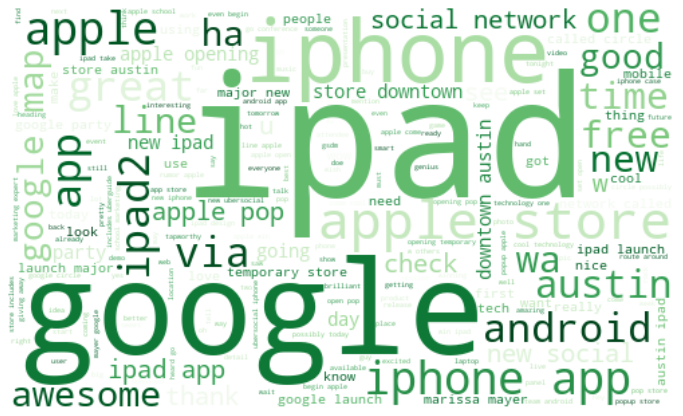

In [1025]:
#generating word cloud

cloud_pos_w_company = generate_wordcloud(tokens_pos_ls, collocations=True)

This visualization offers an excellent overview of what the public was tweeting about positively. We can see that many people were excited about iPads and the iPad 2 launch. Unsurprisingly, they were also tweeting about Apple and Google. To gain even more insight, we can remove product and company names from our word cloud, potentially revealing additional interesting details.

WordCloud without Product/Company Information for Positive Tweets


In [1026]:
#removing product/company names
stop_lst_no_comp = stop_lst + ['ipad', 'apple', 'google', 'iphone', '#apple', 
                               '#google', '#ipad', '#iphone', 'android']
tokens_pos_ls = remove_stop(tokens_pos_ls, stop_list=stop_lst_no_comp)

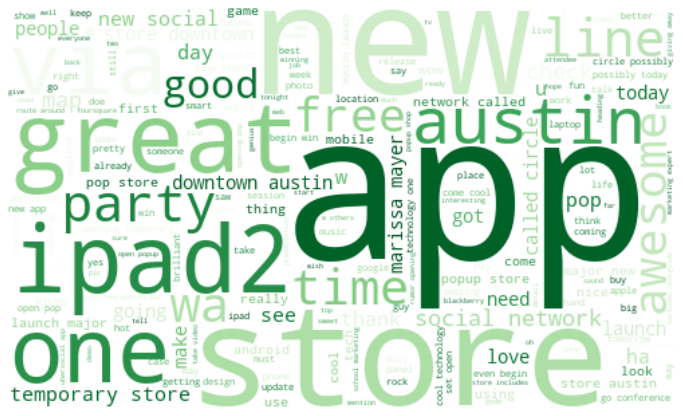

In [1027]:
cloud_pos_wo_company = generate_wordcloud(tokens_pos_ls, collocations=True)


Prominent Words: “app,” “store,” “new,” “great,” and “free.” This word cloud suggests a positive sentiment towards an app or store, highlighting its newness, greatness, and the fact that it might be free.

Bigrams for Positive Tweets


Similar to the most common 50 words, looking at the most common bigrams can also be helpful in providing context to these tweets.

In [1028]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# Initialize bigram measures
bigram_measures = BigramAssocMeasures()

# Initialize the BigramCollocationFinder with the list of tokens
finder_pos = BigramCollocationFinder.from_words(tokens_pos_ls)

# Get frequency information for bigrams
bigrams = finder_pos.score_ngrams(bigram_measures.raw_freq)

# Display the top 50 bigrams
top_bigrams = bigrams[:50]
top_bigrams


[(('pop-up', 'store'), 0.004338394793926247),
 (('social', 'network'), 0.0032728241427864672),
 (('temporary', 'store'), 0.0030444875746850858),
 (('new', 'social'), 0.0029303192906343953),
 (('store', 'downtown'), 0.00266392662784945),
 (('downtown', 'austin'), 0.0026258705331658866),
 (('2', 'launch'), 0.002207253491646687),
 (('called', 'circle'), 0.0021691973969631237),
 (('network', 'called'), 0.0021691973969631237),
 (('marissa', 'mayer'), 0.00213114130227956),
 (('launch', 'major'), 0.0020550291129124328),
 (('major', 'new'), 0.0020550291129124328),
 (('popup', 'store'), 0.0020550291129124328),
 (('store', 'austin'), 0.0019028047341781787),
 (('pop', 'store'), 0.0017505803554439244),
 (('austin', '2'), 0.0016364120713932336),
 (('opening', 'temporary'), 0.0016364120713932336),
 (('possibly', 'today'), 0.0015602998820261065),
 (('circle', 'possibly'), 0.0015222437873425429),
 (('even', 'begin'), 0.0015222437873425429),
 (('cool', 'technology'), 0.0012939072192411614),
 (('ever', 

Our analysis again reveals widespread excitement surrounding several topics: a new temporary pop-up store downtown, the iPad 2 launch, Google executive Marissa Mayer, and a new social network called Circle.

Having gained this preliminary insight into the positive tweets, we can now turn our attention to examining the negative tweets.

Tweets with Negative Sentiment


In [1029]:
#parsing positive tweets into new df
df_negative = df[df['Sentiment']=='Negative']
#verifying that neutral and negative tweets have been removed
df_negative['Sentiment'].value_counts()

Negative    569
Name: Sentiment, dtype: int64

In [1030]:
# Convert 'Tweet' column to a list
corpus_neg = df_negative['Tweet'].tolist()  

# Display the first 5 tweets
print(corpus_neg[:5])

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.', "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw", 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone', '@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW', 'Again? RT @mention Line at the Apple store is insane.. #sxsw']


Tokenization, Lemmatization, and Stop Word Removal

We need to break down text into individual units, called tokens to helps in analyzing the structure of the text and makes it easier to process the data for further analysis then lemmatization which considers the context and converts a word into its meaningful base form and finally Stop words are common words that usually add little meaning to a sentence such as "the," "is," and "in." To helps to reduce noise in the data, allowing for more focused analysis on the significant words that contribute to the overall meaning.

In [1031]:
# Function to tokenize tweets
tokens_neg = tokenize_tweets(corpus_neg)

# Function to lemmatize the tokens
tokens_neg_lemm = lemmatize_tokens(tokens_neg)

# Function to remove stop words and punctuation
tokens_neg_ls = remove_stop(tokens_neg_lemm, stop_list=stop_lst)


30 Most Frequent Words in Negative Tweets

In [1032]:
# Convert to DataFrame
df_frequent_tokens = pd.DataFrame(frequent_tokens_neg, columns=['Token', 'Count'])

# Display the DataFrame
print(df_frequent_tokens)

      Token  Count
0      ipad    179
1    iphone    145
2    google    136
3     apple    100
4         2     81
5               69
6       app     60
7     store     47
8       new     43
9      like     43
10     need     35
11       ha     31
12   circle     29
13   design     29
14   people     29
15   social     28
16     apps     26
17      get     25
18       wa     24
19   austin     23
20    think     23
21     time     23
22   launch     22
23      one     22
24      day     21
25    today     21
26     look     21
27     line     20
28      say     20
29  android     19


Creating a Word Cloud Featuring Product/Brand Information from Negative Tweets.

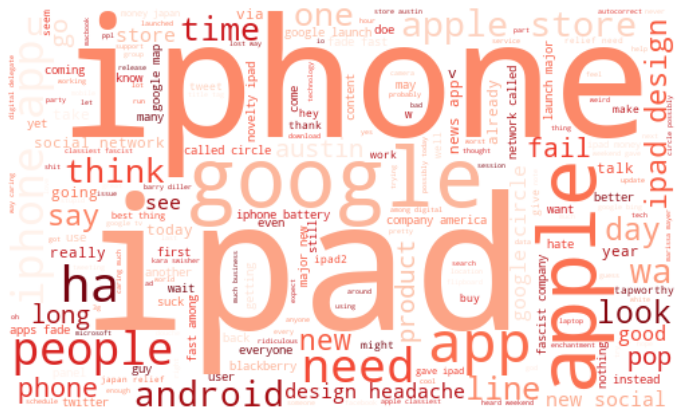

In [1033]:
# Generate a word cloud for negative tweets
cloud_neg_w_company = generate_wordcloud(
    tokens_neg_ls,
    colormap='Reds',
    collocations=True
)


It looks like the iPad and the iPhone are mentioned often in the negative tweets along with their designs with Google and Android also visible. Once again, we can remove the company names and product lines to see if we can see any additional information.

WordCloud without Product/Brand Information for Negative Tweets


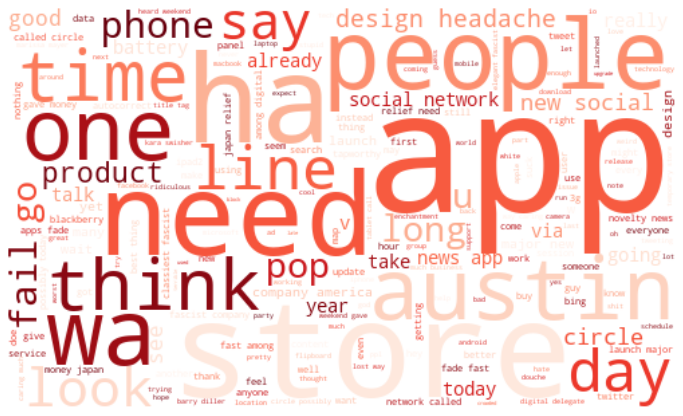

In [1034]:
#removing company/product information from the tokens
tokens_neg_ls = remove_stop(tokens_neg_ls, stop_list=stop_lst_no_comp)
#generating word cloud
cloud_neg_wo_company = generate_wordcloud(tokens_neg_ls, colormap='Reds', 
                                          collocations=True)

Prominent Words: “app,” “store,” “new,” “bad,” and “expensive.” This word cloud indicates a negative sentiment, focusing on the app or store being bad and expensive, despite being new.

Bigrams for Negative Tweets


In [1035]:
# Initialize the BigramCollocationFinder with negative tokens
finder_neg = BigramCollocationFinder.from_words(tokens_neg_ls)

# Retrieve frequency information for the bigrams
bigrams_neg = finder_neg.score_ngrams(bigram_measures.raw_freq)

# Display the top 50 bigrams based on frequency
top_bigrams_neg = bigrams_neg[:50]
top_bigrams_neg


[(('design', 'headache'), 0.0032486145614370344),
 (('new', 'social'), 0.0030575195872348557),
 (('social', 'network'), 0.0028664246130326774),
 (('company', 'america'), 0.0024842346646283204),
 (('fascist', 'company'), 0.0022931396904261416),
 (('major', 'new'), 0.0022931396904261416),
 (('network', 'called'), 0.0021020447162239633),
 (('called', 'circle'), 0.0019109497420217848),
 (('launch', 'major'), 0.0019109497420217848),
 (('fade', 'fast'), 0.0017198547678196063),
 (('fast', 'among'), 0.0017198547678196063),
 (('news', 'apps'), 0.0017198547678196063),
 (('novelty', 'news'), 0.0017198547678196063),
 (('#japan', 'relief'), 0.0015287597936174278),
 (('2', 'money'), 0.0015287597936174278),
 (('best', 'thing'), 0.0015287597936174278),
 (('classiest', 'fascist'), 0.0015287597936174278),
 (('gave', '2'), 0.0015287597936174278),
 (("i've", 'heard'), 0.0015287597936174278),
 (('need', '2'), 0.0015287597936174278),
 (('relief', 'need'), 0.0015287597936174278),
 (('thing', "i've"), 0.00152

Examining the bigrams once again it reveals that the new social network, Circle, is now being mentioned negatively (in contrast to its previous positive mentions). Additionally, there appear to be some comments about the companies themselves.

Compairing  Positive & Negative Tweets

In [1036]:
def compare_wordclouds(wc1, wc2):
    """
    Plots two word clouds side-by-side for easy comparison.

    Arguments:
    wc1: First word cloud to be plotted.
    wc2: Second word cloud to be plotted.
    """
    # Create a figure with two subplots
    fig, ax = plt.subplots(figsize=(30, 20), ncols=2)
    
    # Display the first word cloud
    ax[0].imshow(wc1)
    ax[0].axis('off')  # Hide x and y ticks
    
    # Display the second word cloud
    ax[1].imshow(wc2)
    ax[1].axis('off')  # Hide x and y ticks
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


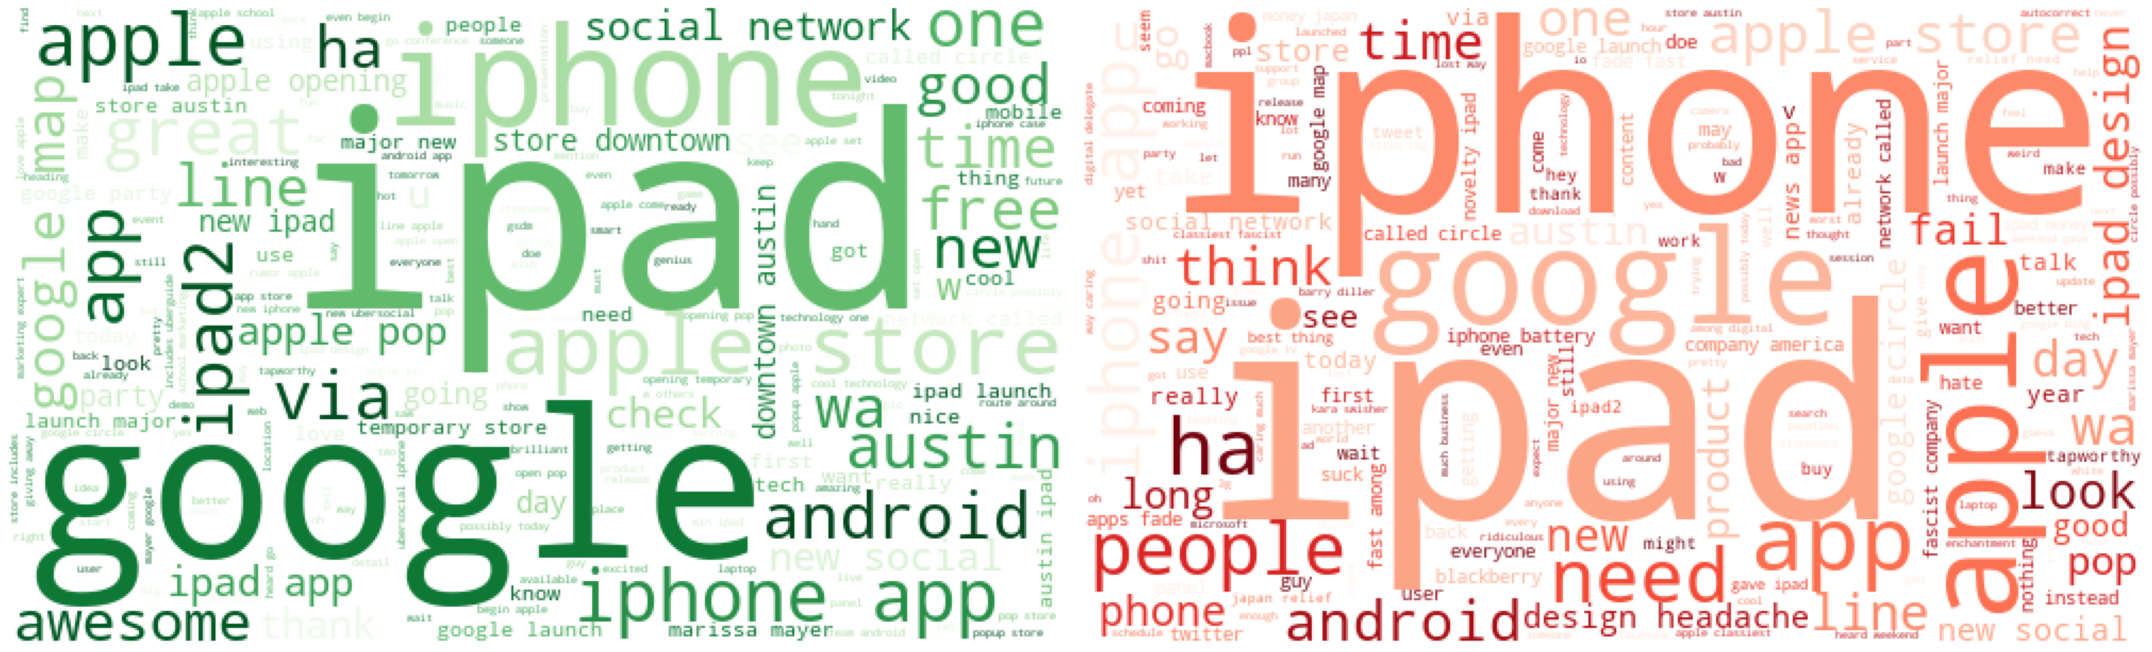

In [1037]:
compare_wordclouds(cloud_pos_w_company, cloud_neg_w_company)

The analysis reveals that both Apple and Google, along with their respective products, are frequently mentioned in tweets with both positive and negative sentiments. While these word clouds provide an initial overview, they do not offer sufficient granularity to draw specific conclusions about the companies or their products.

Without Product/Brand Information


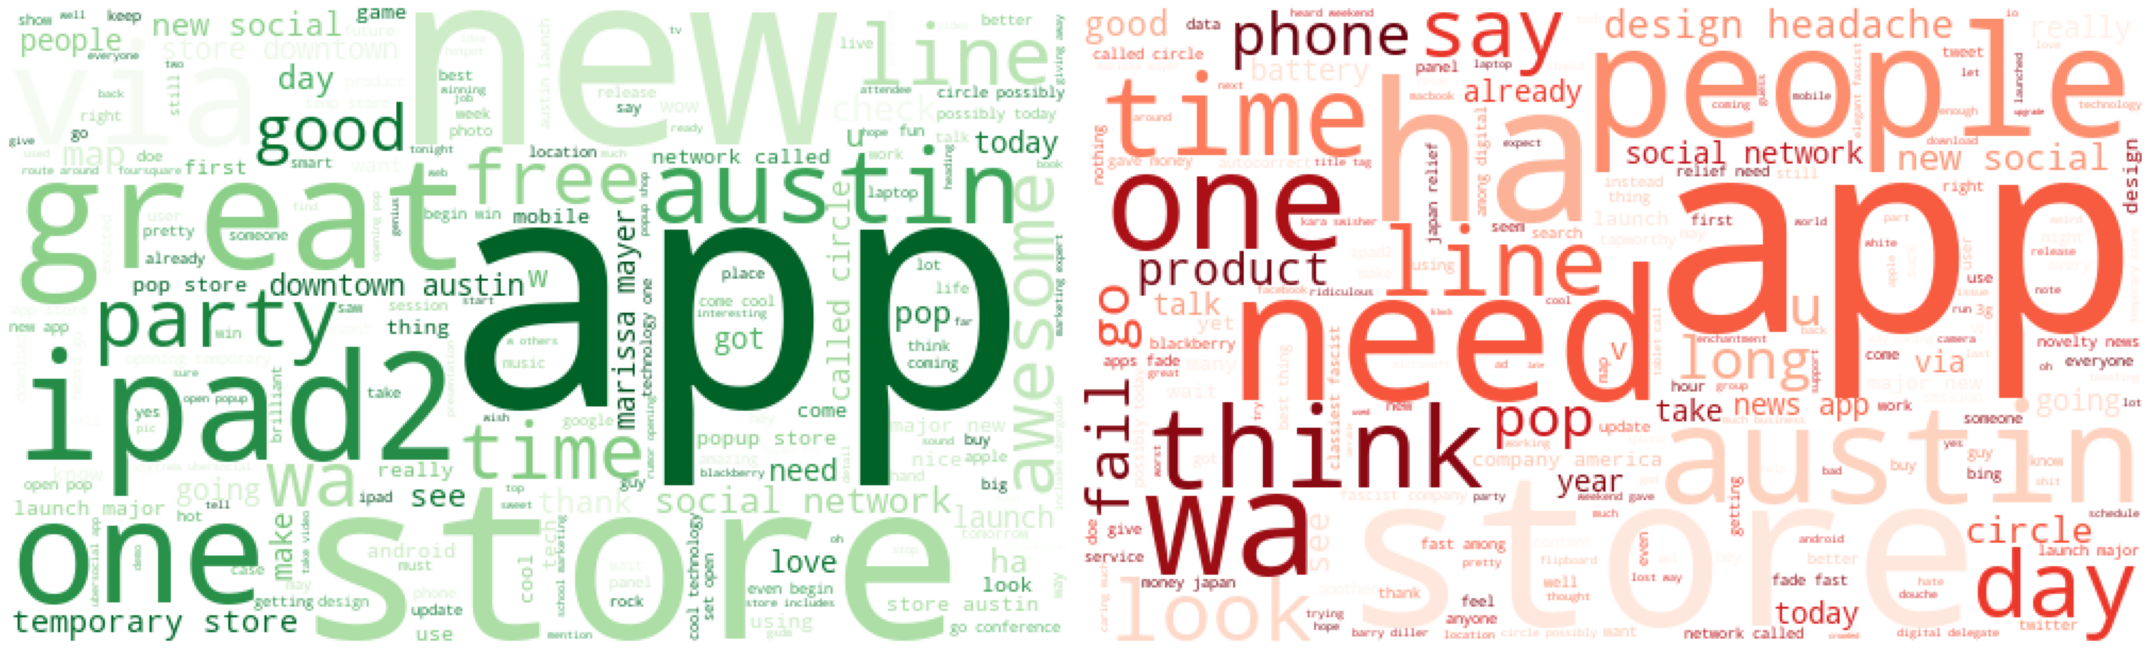

In [1038]:
# Call the function to compare positive and negative word clouds without company names
compare_wordclouds(cloud_pos_wo_company, cloud_neg_wo_company)



The comparison shows that while both word clouds focus on an app or store, the positive one emphasizes positive attributes like greatness and being free, whereas the negative one highlights negative aspects like being bad and expensive.

This exercise provided context about the event rather than detailed insights. Specific company-related sentiments couldn't be determined from the word clouds alone.

To interpret the word clouds, we first established a basic understanding of the conference. Key words like "opening," "apple store," and "downtown Austin" led to further research. We discovered Apple had announced a temporary pop-up store in downtown Austin before the conference, promoting the iPad 2 launch. This resulted in fans queuing for the new iPad.

1. How is Apple perceived as a company during the SXSW Conference, and how does this compare to Google as one of their main competitors?

To answer this question, we will be making our analysis more granular and look at tweets not only based on their sentiment but also based on specific companies and products

Tweets Related to Google


In [1039]:
df['Product/Brand'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', 'Unknown',
       'Android', 'Apple', 'Android App',
       'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [1040]:
# Mapping products to brands
brand_dict = {
    'iPhone': 'Apple', 
    'iPad or iPhone App': 'Apple', 
    'iPad': 'Apple', 
    'Google': 'Google', 
    'Unknown': 'Unknown',
    'Android': 'Google', 
    'Apple': 'Apple', 
    'Android App': 'Google',
    'Other Google product or service': 'Google',
    'Other Apple product or service': 'Apple'
}

# Map the 'Product/Brand' column to 'Brand' using the dictionary
df['Brand'] = df['Product/Brand'].map(brand_dict)

# Display unique brand values
unique_brands = df['Brand'].unique()
print(unique_brands)


['Apple' 'Google' 'Unknown']


In [1041]:
# Filter the DataFrame for tweets related to Google
df_google = df[df['Brand'] == 'Google']

# Create a list of tweets for Google
corpus_google = df_google['Tweet'].to_list()


In [1042]:
# Tokenize the tweets for Google
tokens_google = tokenize_tweets(corpus_google)

# Lemmatize the tokens
tokens_google_lemm = lemmatize_tokens(tokens_google)

# Remove stop words and punctuation using the specified stop words list
tokens_google_ls = remove_stop(tokens_google_lemm, stop_list=stop_lst)


WordCloud with Product/Brand Information


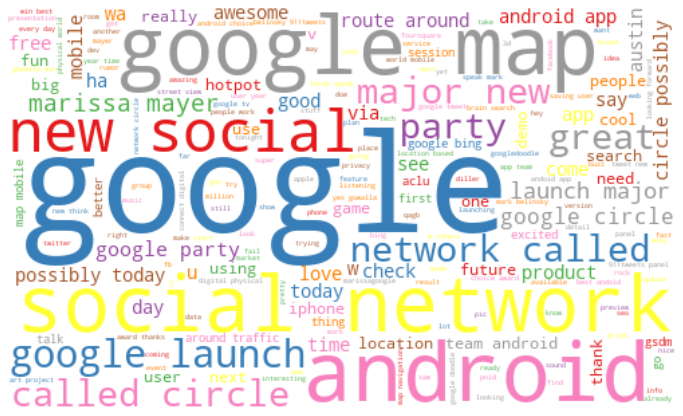

In [1043]:
#generating word cloud for negative tweets
generate_wordcloud(tokens_google_ls, colormap='Set1', collocations=True)

Word Cloud without Product/Brand Information


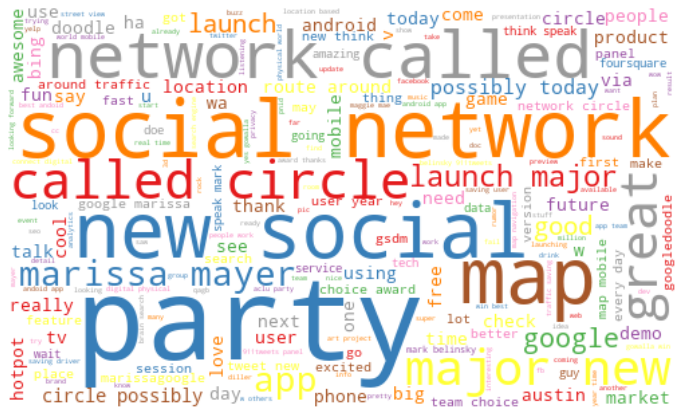

In [1044]:
# Remove stop words using the specified list without company names
tokens_google_ls = remove_stop(tokens_google_ls, stop_list=stop_lst_no_comp)

# Generate a word cloud for the cleaned Google tweet tokens
generate_wordcloud(tokens_google_ls, colormap='Set1', collocations=True)


Percentage of Positive, Neutral and Negative Sentiment

In [1045]:
df__sentiment = pd.DataFrame(df_google['Sentiment'].value_counts(normalize=True)).reset_index()
df_google_sentiment.columns=['Sentiment', 'Percentage']
display(df_google_sentiment)
df_google_sentiment.sort_values('Percentage', ascending=True, inplace=True)

Sentiment  Percentage
2   Neutral    0.035129
1  Negative    0.159251
0  Positive    0.805621

Text(0.5, 1.0, 'Sentiment Percentages for Tweets about Google')

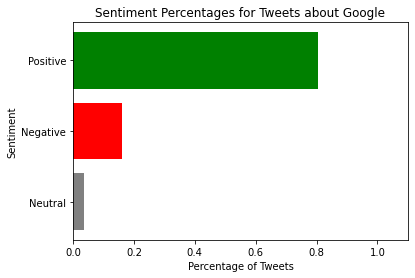

In [1046]:
# Create a horizontal bar chart for sentiment percentages
fig, ax = plt.subplots()

# Plot the data
ax.barh(df_google_sentiment['Sentiment'], df_google_sentiment['Percentage'], color=['Grey', 'Red', 'Green'])

# Set x-axis limits and labels
ax.set_xlim(0, 1.1)
ax.set_xlabel('Percentage of Tweets')

# Set y-axis label and title
ax.set_ylabel('Sentiment')
ax.set_title('Sentiment Percentages for Tweets about Google')

# Display th

Sentiment Analysis on Apple Related Products/Services

Positive Sentiment by Product/Service Type


In [1047]:
# Defining function that generates product word clouds based on Google and emotion
def generate_product_wordcloud(company, emotion, stop_lst, colormap='Set1'):
    """Function generates word clouds for products/services associated with Google 
    based on the specified emotion. The word cloud objects and the figure showing 
    the word clouds are returned respectively.
    -------------------------------
    Arguments:
    emotion: emotion of tweets that the word cloud will be based on
    stop_lst: a list containing stop words to be removed from tokens"""
    
    # Filter the DataFrame for Google and the specified emotion
    final_df = df_google[df_google['Sentiment'] == emotion]
    product_lst = list(final_df['Product/Brand'].unique())
    
    wordclouds = {}
    
    for product in product_lst:
        token_df = final_df[final_df['Product/Brand'] == product]
        corpus = token_df['Tweet'].to_list()
        
        # Tokenize tweets
        tokens_google = tokenize_tweets(corpus)
        # Lemmatize tweets
        tokens_google_lemm = lemmatize_tokens(tokens_google)
        # Remove stop words & punctuation using the specified stop words list
        tokens_google_ls = remove_stop(tokens_google_lemm, stop_list=stop_lst)
        
        wordclouds[product] = generate_wordcloud(tokens_google_ls, 
                                                 collocations=True, 
                                                 colormap=colormap, 
                                                 display=False)
    
    fig, ax = plt.subplots(figsize=(30, 40), nrows=len(wordclouds))
    for i, product in enumerate(product_lst):
        ax[i].set_title(product)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(wordclouds[product])
        
    plt.tight_layout()
    
    return wordclouds, fig


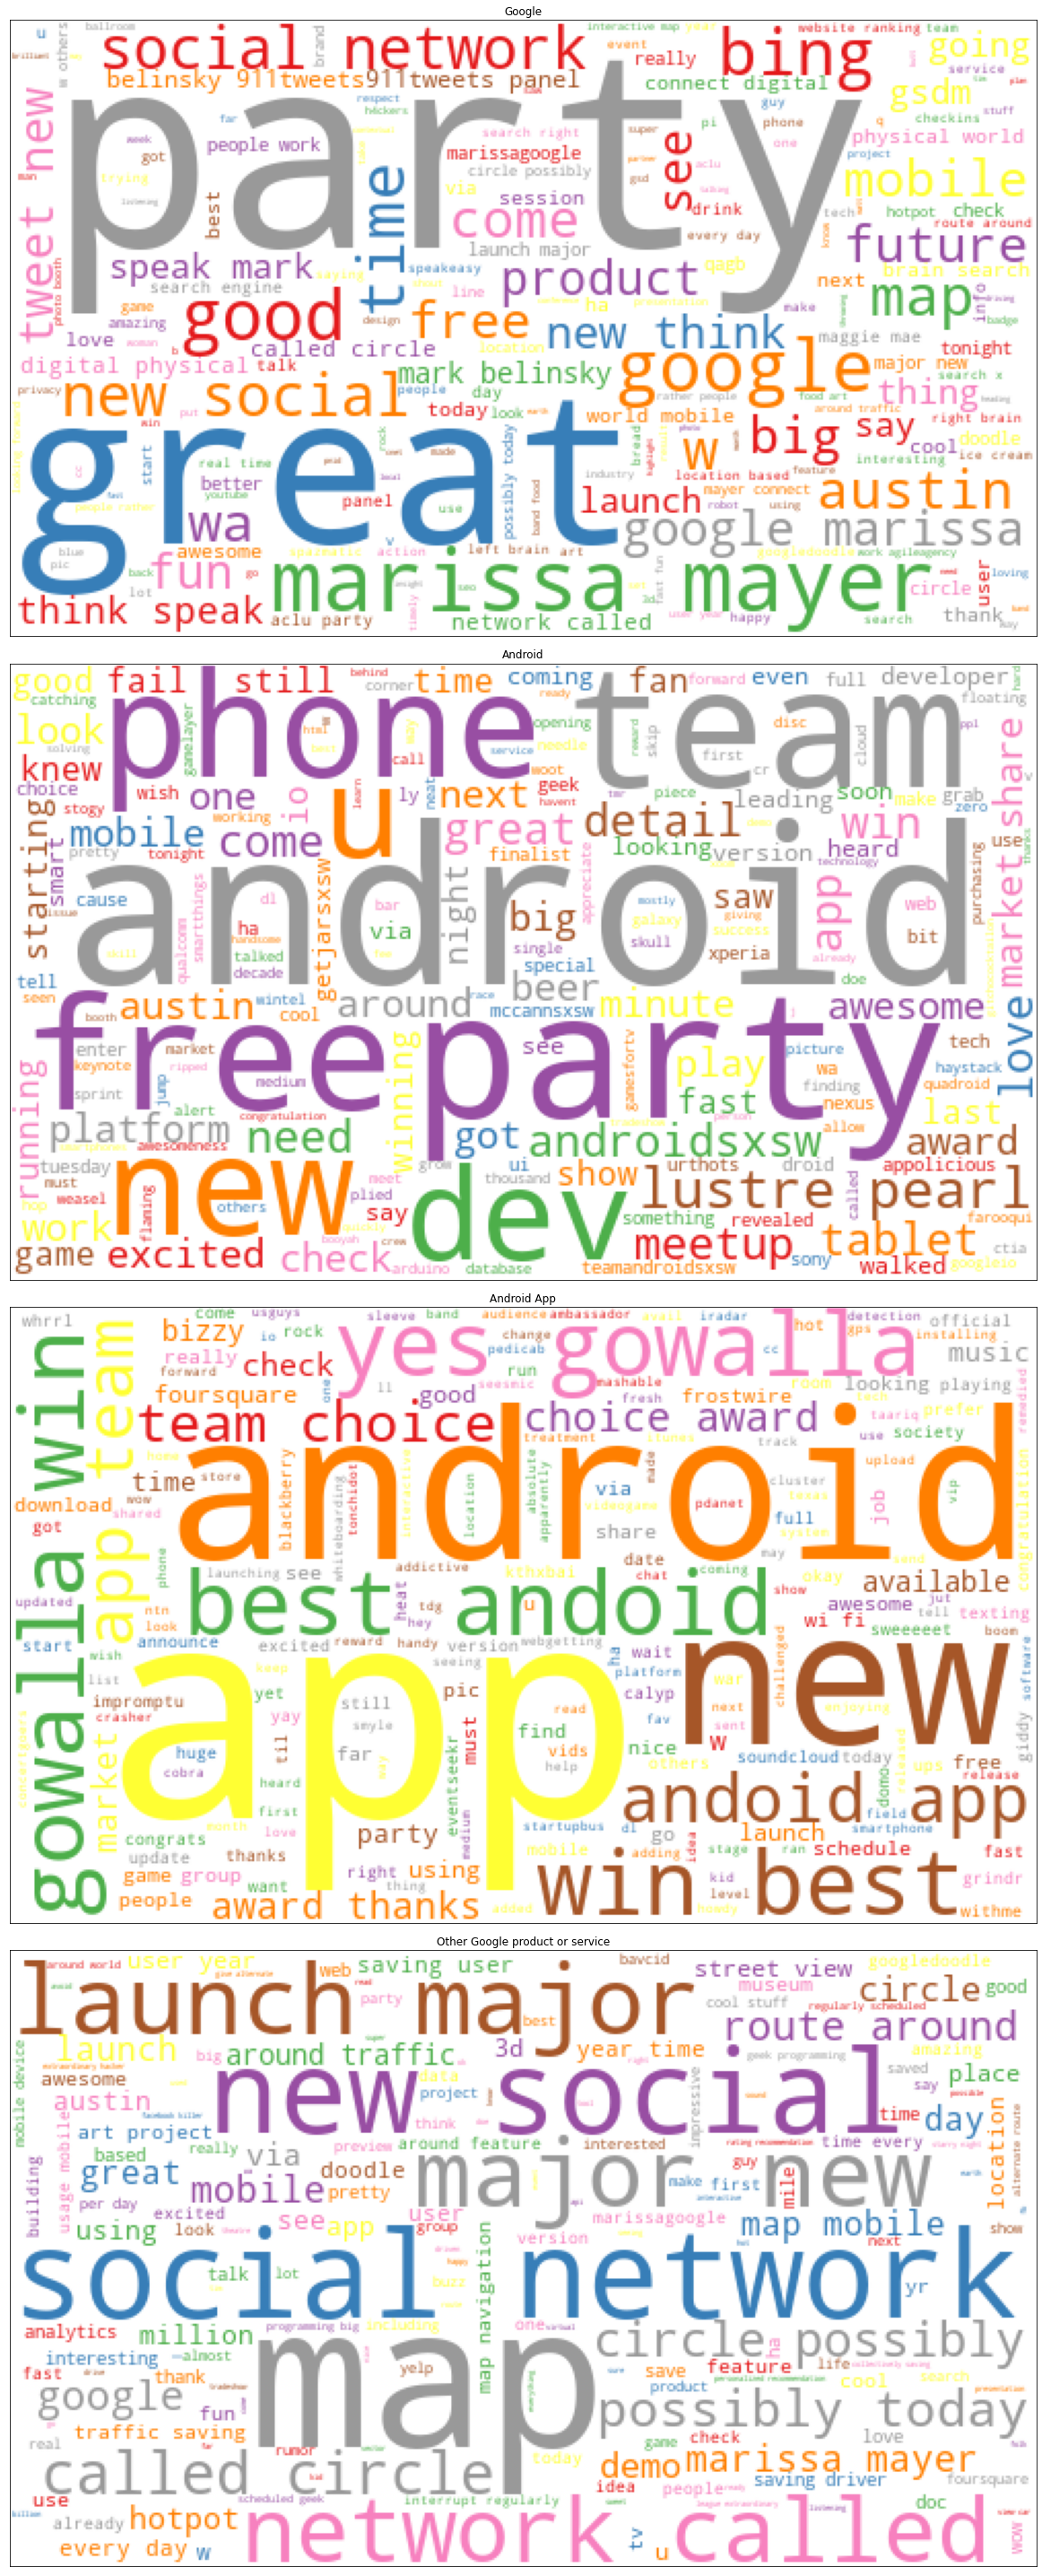

In [1048]:
wordcloud_google_pos, fig_google_pos = generate_product_wordcloud('google', 
                                                                'Positive', 
                                                                stop_lst_no_comp)

The word cloud analysis indicates notable interest in a social event, presumably at a venue called "Lustre Pearl." Furthermore, the frequent occurrence of terms like "new social" and "social network" in conjunction with "Marissa Mayer" suggests that her presentation generated significant positive attention for Google's brand. It may be prudent for Apple to assess this social network initiative to determine if a competitive offering would be beneficial.

In relation to Android applications, "Gowalla" is repeatedly mentioned in association with a "choice award." Moreover, the term "map" appears under the category "Other Google product or service," implying user satisfaction with Google Maps. This is an aspect that Apple may wish to consider in their strategic planning.

Negative Sentiment by Product/Service Type


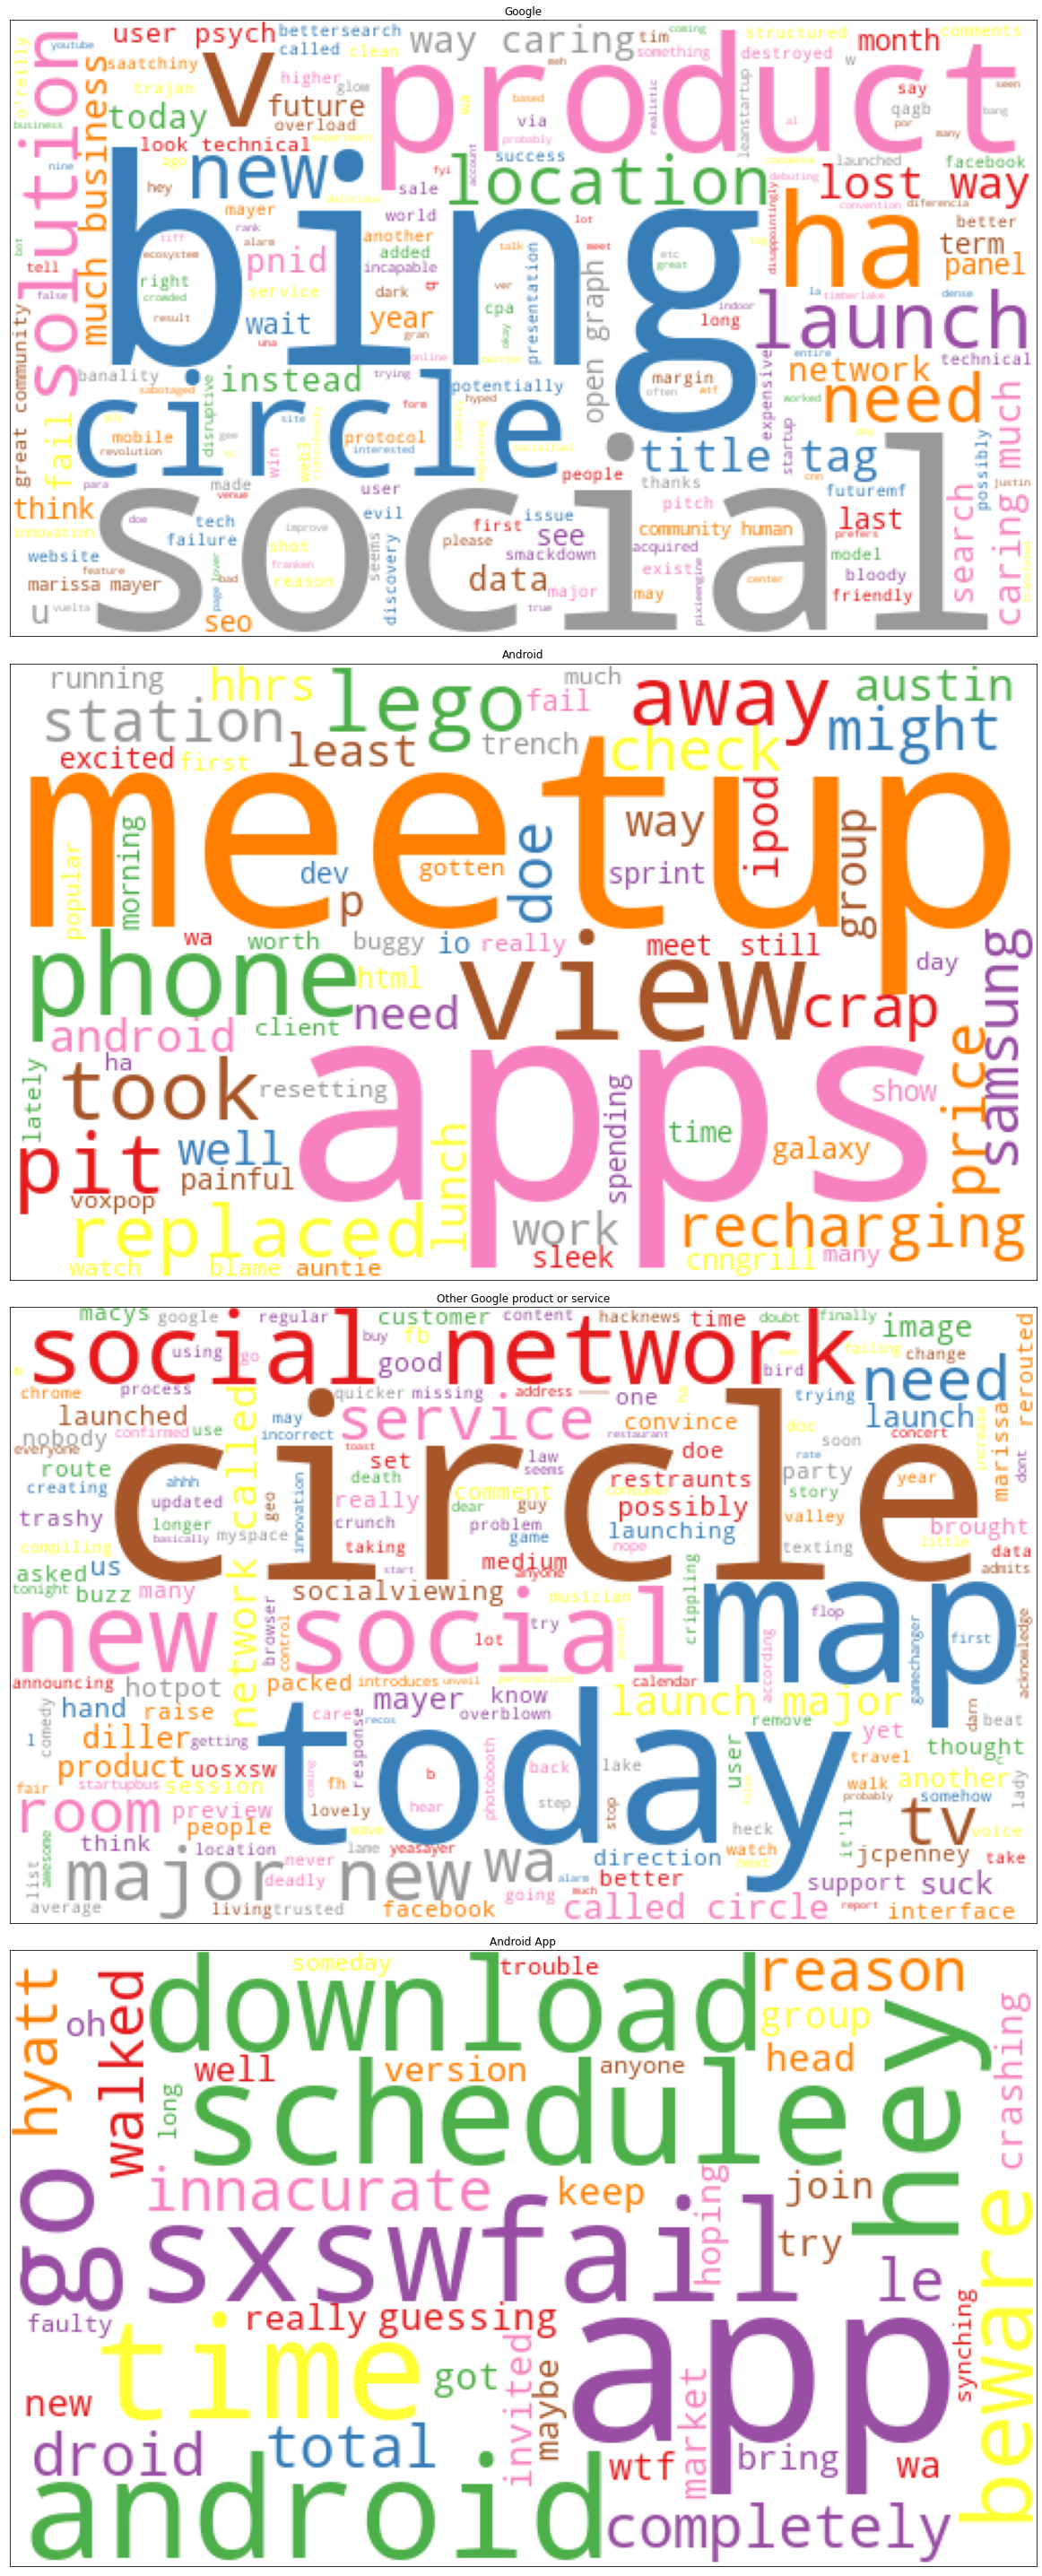

In [1049]:
# Generate word cloud for negative tweets about Google
wordcloud_google_neg, fig_google_neg = generate_product_wordcloud(
    company='Google', 
    emotion='Negative', 
    stop_lst=stop_lst_no_comp
)

# Check if the word cloud generation was successful
if wordcloud_google_neg is None or fig_google_neg is None:
    print("Word cloud generation failed.")
else:
    # Display the figure if successful
    plt.show(fig_google_neg)


Regarding negative sentiments, Microsoft's Bing is frequently mentioned, indicating a potential preference for Google's search engine among users. It's worth noting that while the new social network announcement garnered positive attention, it also appeared in negative contexts. Additionally, comments about the Android OS include terms such as "buggy," "replaced," and "painful," which may present a strategic opportunity for Apple's iOS platform.

DATA MODELLING 

With the established understanding that tweets can offer valuable insights into public opinion, our next step is to develop and evaluate various machine learning models. While our current dataset relies on crowdsourced information, it is essential for Apple to implement a more robust system for real-time analysis of brand-related tweets. To maintain a competitive advantage, it is imperative to create a machine learning model capable of automatically categorizing tweets based on their content.

Our approach consists of two phases: binary and multiclass classification. The binary classification model distinguishes between "positive" and "negative" tweets. The multiclass classification model adds a "neutral" category, creating a three-way classification system. Both methods offer unique applications and significant value for our analysis.

1. Binary Classification

>Data Preparation


In [1050]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

Functionizing Evaluation of Classification Models


In [1051]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix

def classification(y_true, y_pred, X_test, X_train, clf):
    """Displays the classification report, confusion matrix, and ROC curve 
    to evaluate model performance.
    -----------------------------------
    Arguments:
    y_true: The correct labels, typically from the y_test in train_test_split.
    y_pred: The predicted labels from the model.
    clf: The classifier model fitted to the training data.
    X_test: The test features from train_test_split.
    X_train: The training features from train_test_split."""
    
    # Calculate training and test scores
    print(f"Training Score: {round(clf.score(X_train, y_train), 2)} \
            Test Score: {round(clf.score(X_test, y_true), 2)}")
    
    # Display classification report
    print("\nCLASSIFICATION REPORT")
    print("------------------------------------------")
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
    # Create subplots for confusion matrix and ROC curve
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
    # Plot normalized confusion matrix
    plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_true, cmap='Blues', 
                          normalize='true', ax=ax[0], 
                          display_labels=['Negative', 'Positive'])
    
    # Plot ROC curve
    plot_roc_curve(estimator=clf, X=X_test, y=y_true, ax=ax[1])
    
    # Add 50-50 guessing plot for reference
    ax[1].plot([0, 1], [0, 1], ls='--', color='orange')


Creating a New DataFrame

Since we are developing a model for binary classification, we need to exclude neutral emotions from our tweets and convert the 'Emotion' column into a binary format.

In [1052]:
# Remove neutral tweets for binary classification
df_binary = df[df['Sentiment'] != 'Neutral']

# Verify that neutral tweets have been removed
df_binary['Sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

In [1053]:
# Binarize the emotion column
emotion_dict = {'Negative': 0, 'Positive': 1}
df_binary['Sentiment'] = df_binary['Sentiment'].map(emotion_dict)


 Dataset Train_test_split 


In [1054]:
# Split the dataset into training and testing sets
y = df_binary['Sentiment']
X = df_binary['Tweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


Dummy Classifier - Baseline

To evaluate the performance of our models and assess how well they perform compared to random guessing, we will create a dummy classifier as a baseline.

In [1055]:

# Initialize the TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)


Training Score: 0.73             Test Score: 0.74

CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.18      0.20      0.19       134
           1       0.86      0.84      0.85       751

    accuracy                           0.74       885
   macro avg       0.52      0.52      0.52       885
weighted avg       0.75      0.74      0.75       885



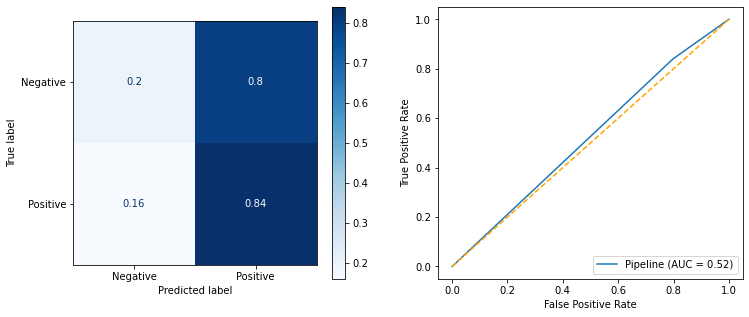

In [1056]:
from sklearn.dummy import DummyClassifier


# Create a pipeline with TF-IDF vectorizer and Dummy Classifier
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_lst)),
    ('clf', DummyClassifier(random_state=42))
])

# Fit the pipeline to the training data
clf_pipe.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf_pipe.predict(X_test)

# Evaluate the model performance
classification(y_test, y_pred, X_test, X_train, clf_pipe)



The model exhibits strong performance in identifying positive sentiments (Class 1), with an accuracy of 74%, an F1-score of 85%, and a precision of 86%. However, it struggles significantly with negative sentiments (Class 0), evidenced by a low precision of 18%, a recall of 20%, and an F1-score of just 19%. This discrepancy highlights the need for improvements in detecting negative sentiments, potentially through techniques like data balancing, feature enhancement, or more advanced modeling approaches.

In [1057]:
df_binary['Sentiment'].value_counts(normalize=True)


1    0.83922
0    0.16078
Name: Sentiment, dtype: float64


The analysis shows a strong bias towards positive sentiments, which can affect model reliability and generalization, emphasizing the need for strategies to address this imbalance.


Randomly Oversampled Baseline Model

We will use Random Oversampled Dummy Model to clarity while emphasizing that it serves as a baseline for comparison in your analysis.

Training Score: 0.5             Test Score: 0.5

CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.15      0.50      0.23       134
           1       0.85      0.50      0.63       751

    accuracy                           0.50       885
   macro avg       0.50      0.50      0.43       885
weighted avg       0.74      0.50      0.57       885



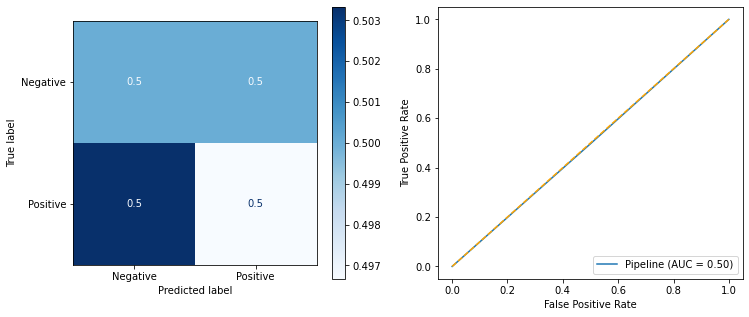

In [1058]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Create a pipeline that includes vectorization, oversampling, and classification
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                     stop_words=stop_lst)),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', DummyClassifier(random_state=42))
])

# Fit the pipeline to the training data
clf_pipe.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_pipe.predict(X_test)

# Evaluate the model's performance
classification(y_test, y_pred, X_test, X_train, clf_pipe)


The model's significant challenges with class imbalance are evident. While it can identify positive sentiments with high precision (85%), it struggles with negative predictions, yielding a precision of only 15%. The overall performance, with an accuracy of 50%, highlights the need for improved modeling techniques and strategies to better balance the class distributions in the dataset.

data balancing, advanced modeling techniques, or tuning might be necessary to improve true negative rates and overall sentiment classification accuracy.

Multinomial Naive Bayes




Pipelines for Preprocessing and Modeling




In [1059]:
# Creating a pipeline to vectorize, remove stop words, and model
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)),
    ('clf', MultinomialNB())
])


Model 1- MNB

Fitting, Predicting, and Evaluating the Model


Training Score: 0.86             Test Score: 0.86

CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.04      0.09       134
           1       0.85      1.00      0.92       751

    accuracy                           0.86       885
   macro avg       0.93      0.52      0.50       885
weighted avg       0.88      0.86      0.79       885



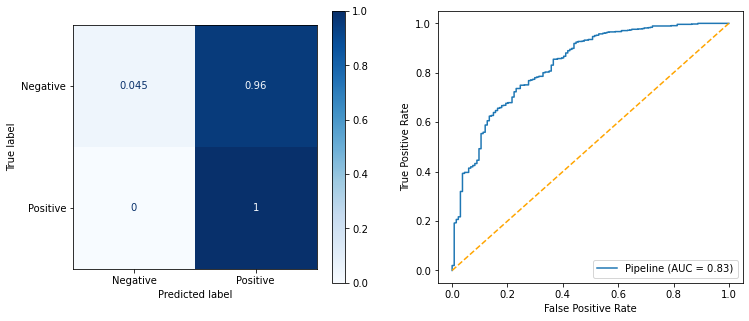

In [1060]:
# Fitting the model, making predictions, and evaluating performance
clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
classification(y_test, y_pred, X_test, X_train, clf_pipe)


The model demonstrates strong performance with positive tweets, achieving high precision and recall. However, it struggles significantly with negative tweets, as evidenced by a low recall of 4% and a very low F1-score of 9%. This suggests a critical need to address class imbalance, as only a small fraction of actual negative tweets are being identified correctly.

Hyperparameter Tuning Using GridSearchCV




In [1063]:

# Define whether to run grid searches
run_gridsearches = True  # Set to False if you want to skip grid search

if run_gridsearches:
    param_grid = {
        'clf__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5],  # Added 0.5 and 5 for a wider range
        'vectorizer__stop_words': [stop_lst, 'english', None]  # Added None to test with no stop words
    }
    gridsearch = GridSearchCV(clf_pipe, param_grid=param_grid, scoring='recall_macro')

    gridsearch.fit(X_train, y_train)
    best_params = gridsearch.best_params_
    print("Best parameters found:", best_params)
else:
    best_params = {'clf__alpha': 0.01, 'vectorizer__stop_words': stop_lst}
    print("Using default parameters:", best_params)


Best parameters found: {'clf__alpha': 0.01, 'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'som

The combination of a low alpha and a comprehensive stop words list indicates a well-tuned model that aims to optimize performance by reducing noise and enhancing the significance of relevant features. This approach can lead to improved accuracy in sentiment analysis by allowing the classifier to focus on more informative tokens in the tweets.

Tuned Multinomial Naive Bayes Model 1

Training Score: 0.98             Test Score: 0.89

CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.46      0.56       134
           1       0.91      0.97      0.94       751

    accuracy                           0.89       885
   macro avg       0.81      0.71      0.75       885
weighted avg       0.88      0.89      0.88       885



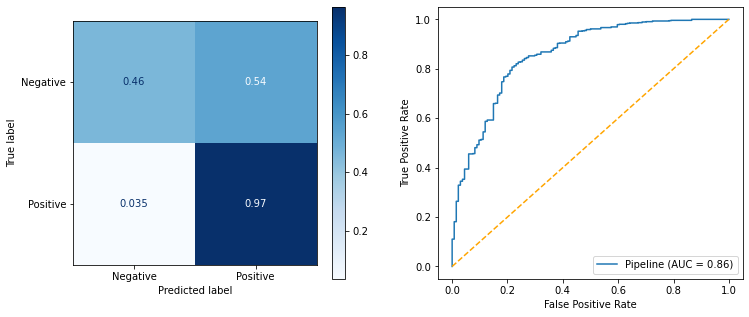

In [1064]:
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)), 
    ('clf', MultinomialNB(alpha=0.01))
])

# Fitting the model to the training data
clf_pipe.fit(X_train, y_train)

# Making predictions on the test set
y_pred = clf_pipe.predict(X_test)

# Evaluating the model's performance
classification(y_test, y_pred, X_test, X_train, clf_pipe)


Overall accuracy of 89% indicates that the model correctly classified 89% of the test instances. Though our predictions on  Negative tweets has improved to recall 0.46 and F1score to 0.56 with gridsearch compaired to baseline, We Could see imbalance in our model, giving room for further optimization. 



 Model 2: MNB Random Oversampling

Training Score: 0.98             Test Score: 0.86

CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       134
           1       0.93      0.90      0.91       751

    accuracy                           0.86       885
   macro avg       0.72      0.75      0.74       885
weighted avg       0.87      0.86      0.86       885



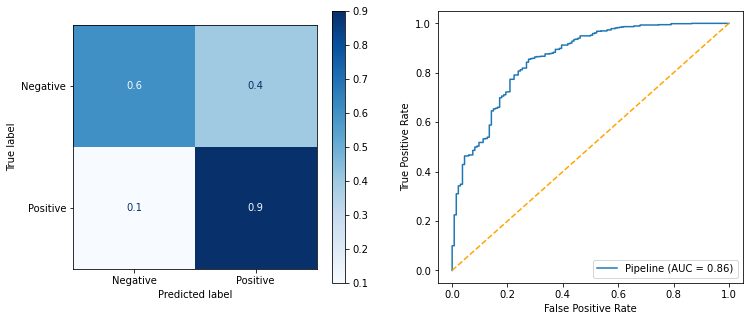

In [1068]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer

# Setting up a machine learning pipeline with Random Oversampling and Multinomial Naive Bayes
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)),
    ('os', RandomOverSampler(random_state=42)),  # Addressing class imbalance
    ('clf', MultinomialNB(alpha=0.1))  # Classifier with tuned hyperparameter
])

# Fitting the model to the training data
clf_pipe.fit(X_train, y_train)

# Making predictions on the test set
y_pred = clf_pipe.predict(X_test)

# Evaluating the model's performance
classification(y_test, y_pred, X_test, X_train, clf_pipe)


There has been some improvement in the recall to 60%  for the negative class, suggesting better identification of negative sentiments.

while there is some progress, further tuning, additional data, or different modeling approaches may be needed to improve the performance on the negative class more substantially.

Random Forest


Model 1